<img src="./images/DLI_Header.png" style="width: 400px;">

# 4. GPT-J deployment with NVIDIA FasterTransformer and Triton Inference server 

In the previous section, we have seen how to take an unoptimized model and significantly accelerate it using FasterTransformer. This is significant, as it allows us to dramatically reduce the size of the capital investment needed to deploy an application as well as the ongoing operational costs. FasterTransformer can frequently be the difference between a non-feasible idea and a product that generates revenue. At the end of the previous notebook, we only had a binary with no real means of serving it to large groups of users. We did not have a way to deploy this binary to production, not to mention, to manage the efficiency of its execution (for example, batching user requests together to increase GPU utilization or overlapping execution of models to reduce request latency). We will address the above and have an application that is close to being ready for production. 

In this notebook we will: 
* Discuss key features of NVIDIA Triton inference server and how it can be integrated with the FasterTransformer Execution Backend. 
* Learn how to prepare the GPT-J for deployment using Triton. 
* Run Triton inference server with GPT-J using a two-way Tensor Parallel deployment. 
* We will write a client application using our model hosted on Triton using Python client API `tritonclient` 


**[4.1 NVIDIA Triton Inference Server](#4.1)<br>** 
**[4.2 Overview of the end-to-end inference pipeline](#4.2)<br>** 
**[4.3 Preparing the inference environment](#4.3)<br>** 
**[4.4 Triton Inference Server configuration](#4.4)<br>** 
**[4.5 Launching Triton Inference Server](#4.5)<br>** 
**[4.6 Writing client application consuming our GPT-J model](#4.6)<br>** 

# 4.1 NVIDIA Triton Inference Server

NVIDIA Triton™ Inference Server, part of the NVIDIA AI platform, is an open-source inference serving software that helps standardize model deployment and execution and delivers fast and scalable AI in production. Triton streamlines AI inference by enabling teams to deploy, run, and scale trained AI models from any framework on any GPU- or CPU-based infrastructure. It provides AI researchers and data scientists the freedom to choose the right framework for their projects without impacting production deployment. It also helps developers deliver high-performance inference across cloud, on-prem, edge, and embedded devices. 
<div style="text-align:center"> 
<img src="./images/FT_custom_backend.PNG" style="width: 60%;position:relative;" /> 
</div> 

Triton inference server is distributed with a number of execution backends including backends supporting TensorRT, PyTorch, custom Python/C++ backend, HugeCTR, OpenVion and many other including FasterTransformer. It can be extended by developers as new backends can also be integrated. [FasterTransfromer execution backend](https://github.com/triton-inference-server/fastertransformer_backend/) written by NVIDIA allows to deploy models optimized using FasterTransformer library not only in a single GPU but also multi-GPU and multi node mode. 

# 4.2 Overview of the end-to-end inference pipeline

Before we dive into the Triton deployment process, let us take a bird's eye view of the end-to-end deployment process. In notebook 1, we have completed steps analogous to 1 and 2 but focused on standalone FasterTransformer environment. We need to create a variant of this environment capable of supporting FasterTransformer execution backend for triton. In notebook 3, we have completed steps 3, 4, 5 and 6 so we will be able to reuse the assets produced at those stages. After we execute steps 1 and 2, we just need to execute steps 7 and 8 namely we will focus on configuring Triton Inference server and its execution. 

<div style="text-align:center">
<img src="./images/FT_TRITON_pipeline_v1.1..PNG" style="width: 70%;position:relative;" />
</div>


# 4.3 Preparing the inference environment

The Fastertransformer_backend for Triton Inference Server is already installed into Triton in our container, so we do not have to deploy it manually. We do need to download `fastertransformer_backend` code from GitHub (https://github.com/triton-inference-server/fastertransformer_backend) to use Triton's configs for GPT-J prepared by NVIDIA. They are placed in <code>fastertransformer_backend/all_models</code>.

In [1]:
!git clone https://github.com/triton-inference-server/fastertransformer_backend
%cd fastertransformer_backend
!git checkout 571a1fce438409087f5d3889237541828cc24ba5
%cd ../

Cloning into 'fastertransformer_backend'...
remote: Enumerating objects: 631, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 631 (delta 164), reused 219 (delta 131), pack-reused 350
Receiving objects: 100% (631/631), 2.80 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (301/301), done.
/dli/task/fastertransformer_backend
Note: switching to '571a1fce438409087f5d3889237541828cc24ba5'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 571a1fc Me

In [2]:
!mkdir triton-model-store
!cp -r ./fastertransformer_backend/all_models/gptj triton-model-store/

Let's have a look at the Triton's config for the GPT-J model `./fastertransformer_backend/all_models/gptj`:

In [3]:
!ls triton-model-store/gptj/

ensemble  fastertransformer  postprocessing  preprocessing


This configuration file is a perfect example of model ensemble in Triton Inference Server. Triton is a general purpose inference server allowing not only to run individual neural networks, but also construct complex ensembles/pipelines. These pipelines may contain multiple neural network stages connected with each other into one inference service. Pipelines can be composed of different components. One can add Python/C++ scripts before and/or after any neural network to add any pre/post processing steps that could transform the data into its final format.  </br> 

In the `GPT-J` inference pipeline we have three distinct execution steps: </br> `preprocessing` -> `model execution with fastertransformer` -> `postprocessing` </br>  

We bring those three pieces together with an `ensemble` defined in Triton configuration file. Overall, the client-server inference scheme looks like this: 

<center>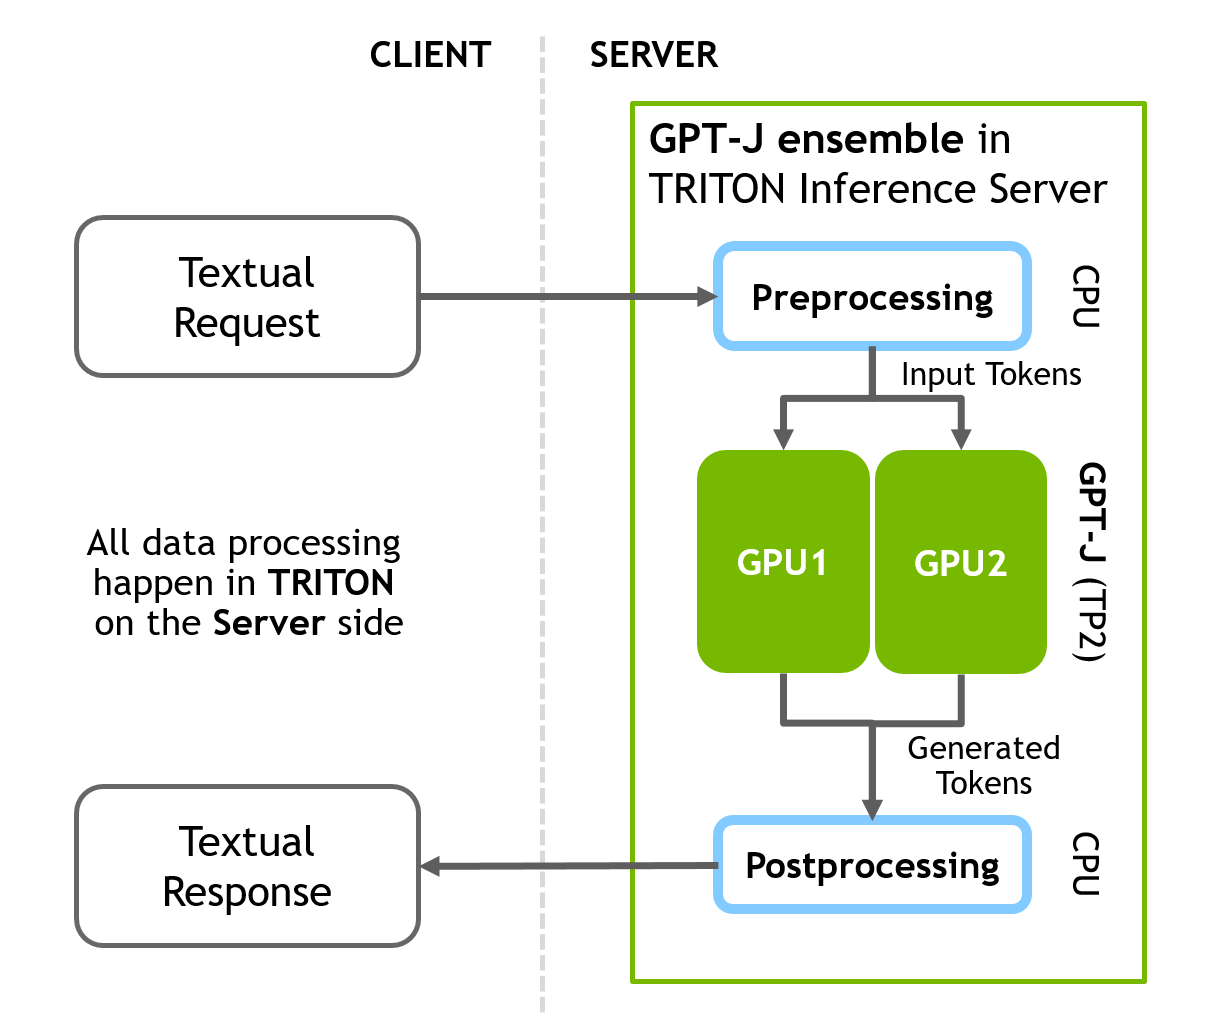</center>


# 4.4 Triton Inference Server configuration

#### Updating model configuration

Let's edit the Triton configuration file responsible for the GPT-J model part of our pipeline. We can do that by editing the following file: <b>["triton-model-store/gptj/fastertransformer/config.pbtxt"]("triton-model-store/gptj/fastertransformer/config.pbtxt)</b> 
Only two parameters need to be changed for us to be able to start inference on our environment:<br/>  
Please update `tensor_para_size` to enable two way tensor parallelism.<br/> 
<code>
parameters {
  key: "tensor_para_size"
  value: {
    string_value: "2"
  }
}
</code> <br/>
Please update the path to the checkpoint prepared for 2-GPU inference (folder from the previous step). <br/>
<code>
parameters {
  key: "model_checkpoint_path"
  value: {
    string_value: "./models/j6b_ckpt/2-gpu/" 
  }
}
 </code> 


#### Kernel autotuning

Consistently to what we have done in the previous notebook in section 3.6.2, we need to prepare execution configuration by executing kernel autotuning.

In [15]:
!CUDA_VISIBLE_DEVICES=3  ./FasterTransformer/build/bin/gpt_gemm 1 1 128 16 256 16384 50256 1 2

[INFO] arguments: 
  batch_size: 1 
  beam_width: 1 
  max_input_len: 128 
  head_num: 16 
  size_per_head: 256 
  inter_size: 16384 
  vocab_size: 50256 
  data_type: 1 
  tensor_para_size: 2 

Device Graphics Device
***Encoder Gemm Testing Begin***
***Cublas Gemm Testing Begin***

-----------------------------
GEMM test 0: [M: 128, K: 4096, N: 6144] context from_tensor * weightQKV
algo_99 costs 0.052ms 
algo_100 costs 0.044ms 
algo_101 costs 0.044ms 
algo_102 costs 0.044ms 
algo_103 costs 0.044ms 
algo_104 costs 0.044ms 
algo_105 costs 0.044ms 
algo_106 costs 0.044ms 
algo_107 costs 0.044ms 
algo_108 costs 0.044ms 
algo_109 costs 0.044ms 
algo_110 costs 0.044ms 
algo_111 costs 0.044ms 
algo_112 costs 0.044ms 
algo_113 costs 0.044ms 
algo_114 costs 0.044ms 
algo_115 costs 0.044ms 
fast_algo 102 costs 0.044 ms
***cublasLt Gemm Testing Beign***
AlgoCount: 3813
return 1 and run heuristic algo
workspacesize==0, run 170 algos
result 000 : algo={ Id=6, tileIdx=18 (128x64) splitK=0 reduc=0 s

This script will test many possible kernels and save the optimal configuration in `gemm_config.in` file. This file needs to be placed in the model directory.

# 4.5 Launching Triton Inference Server

Let us now bring all the parts together and start Triton hosting our GPT-J inference pipeline: </br> 
1. We have built and started Triton docker container with the FasterTransformer backend that supports distributed inference of GPT-J</br> 
2. We have downloaded model weights and converted them into FasterTransforer format. </br> 
3. We have prepared the Triton configuration file 'config.pbtxt'.</br> 

We are ready to start Triton Inference Server! 

The command that we are going to use is as follows: </br> 
<code>"CUDA_VISIBLE_DEVICES=2,3 mpirun -n 1 --allow-run-as-root /opt/tritonserver/bin/tritonserver  --model-repository=./triton-model-store/gptj/ &</code> </br>

Let us look at the command segment at a time:
- CUDA_VISIBLE_DEVICES environment variable chooses which GPU will be used for current task/process/script. We have 4 GPUs on our system, so we will use GPUs 3 and 4 (with numbers 2,3) to be sure that we use unused before GPUs to avoid OOM error.
- mpirun - is a command that will allow us to execute Triton in a mode allowing for multi node execution. In this case the parameter -n indicating the number of nodes is set to 1 meaning that only one server will be used. One could specify higher number deploying across multiple servers in our datacenter. 
- <code>--model-repository=some_path</code>, which points to the directory where we have placed configuration files for all models that Triton will be serving (Triton can happily serve multiple models/pipelines). Triton will automatically scan through this folder, find model configurations, load them onto the GPUs and open the HTTP (8000) and GRPC (8001) ports to handle requests.


<b>We will start Triton as a subprocess using Python's `os.system` API. All output logs will be printed into our jupyter output. We do this to not to block Jupyter, which would stop at this command until triton is terminated.</b></br>
If Triton starts successfully, we will see these lines in the output. </br>
It will display information about the ensemble of GPT-J stages that were found by the Triton in our model directory: </br>

<code>
+-------------------+---------+--------+
| Model             | Version | Status |
+-------------------+---------+--------+
| ensemble          | 1       | READY  |
| fastertransformer | 1       | READY  |
| postprocessing    | 1       | READY  |
| preprocessing     | 1       | READY  |
+-------------------+---------+--------+</code>
</br></br>
It will also display information about successful service initialization: </br>

<code>
I0503 17:26:25.226719 1668 grpc_server.cc:4421] Started GRPCInferenceService at 0.0.0.0:8001
I0503 17:26:25.227017 1668 http_server.cc:3113] Started HTTPService at 0.0.0.0:8000
I0503 17:26:25.283046 1668 http_server.cc:178] Started Metrics Service at 0.0.0.0:8002</code>


In [16]:
import os
os.system("CUDA_VISIBLE_DEVICES=2,3 mpirun -n 1 --allow-run-as-root /opt/tritonserver/bin/tritonserver  --model-repository=./triton-model-store/gptj/ &")

0

I0323 22:15:13.995418 10849 metrics.cc:298] Collecting metrics for GPU 0: Graphics Device
I0323 22:15:13.995589 10849 metrics.cc:298] Collecting metrics for GPU 1: Graphics Device
I0323 22:15:14.215486 10849 libtorch.cc:1227] TRITONBACKEND_Initialize: pytorch
I0323 22:15:14.215532 10849 libtorch.cc:1237] Triton TRITONBACKEND API version: 1.7
I0323 22:15:14.215535 10849 libtorch.cc:1243] 'pytorch' TRITONBACKEND API version: 1.7
2023-03-23 22:15:14.328974: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-03-23 22:15:14.352362: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
I0323 22:15:14.352437 10849 tensorflow.cc:2176] TRITONBACKEND_Initialize: tensorflow
I0323 22:15:14.352458 10849 tensorflow.cc:2186] Triton TRITONBACKEND API version: 1.7
I0323 22:15:14.352463 10849 tensorflow.cc:2192] 'tensorflow' TRITONBACKEND API version: 1.7
I0323 22:15:14

[FT][WARNING] Custom All Reduce only supports 8 Ranks currently. Using NCCL as Comm.


I0323 22:15:15.885852 10849 libfastertransformer.cc:307] Before Loading Model:


after allocation, free 77.75 GB total 79.35 GB
after allocation, free 77.75 GB total 79.35 GB


# 4.6 Writing client application consuming our GPT-J model

Finally, we are ready to consume our GPT-J model. We will write a simple python application sending text input to the server using Python's tritonclient library. 

We will send requests to the "ensemble" model not to the GPT-J part as we want pre and post processing to be executed on the server side. Triton is flexible, and we can separately request just the GPT-J model or any part of the pipeline. 

In [17]:
import numpy as np
import tritonclient.http as httpclient

from tritonclient.utils import np_to_triton_dtype

URL = "localhost:8000"
MODEl_GPTJ_FASTERTRANSFORMER = "ensemble" 

OUTPUT_LEN = 128
BATCH_SIZE = 1
BEAM_WIDTH = 1
TOP_K = 1
TOP_P = 0.0

start_id = 220
end_id = 50256

To create an instance of the `client`:

In [18]:
client = httpclient.InferenceServerClient("localhost:8000",
                                           concurrency=1,
                                           verbose=False)

I0323 22:15:26.624169 10849 libfastertransformer.cc:321] After Loading Model:
I0323 22:15:26.652322 10849 libfastertransformer.cc:537] Model instance is created on GPU Graphics Device
I0323 22:15:26.652487 10849 python.cc:1897] TRITONBACKEND_ModelInstanceInitialize: preprocessing_0 (CPU device 0)
I0323 22:15:26.653136 10849 model_repository_manager.cc:1149] successfully loaded 'fastertransformer' version 1


after allocation, free 71.36 GB total 79.35 GB
after allocation, free 71.36 GB total 79.35 GB


I0323 22:15:27.412432 10849 model_repository_manager.cc:1149] successfully loaded 'preprocessing' version 1
I0323 22:15:27.412972 10849 model_repository_manager.cc:994] loading: ensemble:1
I0323 22:15:27.513528 10849 model_repository_manager.cc:1149] successfully loaded 'ensemble' version 1
I0323 22:15:27.513819 10849 server.cc:519] 
+------------------+------+
| Repository Agent | Path |
+------------------+------+
+------------------+------+

I0323 22:15:27.513897 10849 server.cc:546] 
+-------------------+-----------------------------------------------------------------------------+--------+
| Backend           | Path                                                                        | Config |
+-------------------+-----------------------------------------------------------------------------+--------+
| pytorch           | /opt/tritonserver/backends/pytorch/libtriton_pytorch.so                     | {}     |
| onnxruntime       | /opt/tritonserver/backends/onnxruntime/libtriton_

We will implement a function `prepare inputs` that prepares input text and other inference hyperparameters such as `Top-k`, `Top-P`, `Temperature`, etc. There are 15 different hyperparameters that need to be defined for the GPT-J `ensemble` execution. 

In [19]:
# Inference hyperparameters
def prepare_tensor(name, input):
    tensor = httpclient.InferInput(
        name, input.shape, np_to_triton_dtype(input.dtype))
    tensor.set_data_from_numpy(input)
    return tensor

# explanation
def prepare_inputs(input0):
    bad_words_list = np.array([[""]], dtype=object)
    stop_words_list = np.array([[""]], dtype=object)
    input0_data = np.array(input0).astype(object)
    output0_len = np.ones_like(input0).astype(np.uint32) * OUTPUT_LEN
    runtime_top_k = (TOP_K * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    runtime_top_p = TOP_P * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    beam_search_diversity_rate = 0.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    temperature = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    len_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    repetition_penalty = 1.0 * np.ones([input0_data.shape[0], 1]).astype(np.float32)
    random_seed = 0 * np.ones([input0_data.shape[0], 1]).astype(np.int32)
    is_return_log_probs = True * np.ones([input0_data.shape[0], 1]).astype(bool)
    beam_width = (BEAM_WIDTH * np.ones([input0_data.shape[0], 1])).astype(np.uint32)
    start_ids = start_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)
    end_ids = end_id * np.ones([input0_data.shape[0], 1]).astype(np.uint32)

    inputs = [
        prepare_tensor("INPUT_0", input0_data),
        prepare_tensor("INPUT_1", output0_len),
        prepare_tensor("INPUT_2", bad_words_list),
        prepare_tensor("INPUT_3", stop_words_list),
        prepare_tensor("runtime_top_k", runtime_top_k),
        prepare_tensor("runtime_top_p", runtime_top_p),
        prepare_tensor("beam_search_diversity_rate", beam_search_diversity_rate),
        prepare_tensor("temperature", temperature),
        prepare_tensor("len_penalty", len_penalty),
        prepare_tensor("repetition_penalty", repetition_penalty),
        prepare_tensor("random_seed", random_seed),
        prepare_tensor("is_return_log_probs", is_return_log_probs),
        prepare_tensor("beam_width", beam_width),
        prepare_tensor("start_id", start_ids),
        prepare_tensor("end_id", end_ids),
    ]
    return inputs

We can input any prompt for the GPT-J model and execute the cell:

In [20]:
print("Write an input prompt for the model and execute the cell:")
input_user = input()
input0 = [[input_user],]
inputs = prepare_inputs(input0)

Write an input prompt for the model and execute the cell:


 What is your name?


Send the request to the server.</br>
<b>We will see output logs of the Triton server together with our generated output.</b>

In [21]:
result = client.infer(MODEl_GPTJ_FASTERTRANSFORMER, inputs)
output0 = result.as_numpy("OUTPUT_0")
print(output0)

W0323 22:15:47.650855 10849 libfastertransformer.cc:1397] model fastertransformer, instance fastertransformer_0, executing 1 requests
W0323 22:15:47.650909 10849 libfastertransformer.cc:638] TRITONBACKEND_ModelExecute: Running fastertransformer_0 with 1 requests
W0323 22:15:47.650919 10849 libfastertransformer.cc:693] get total batch_size = 1
W0323 22:15:47.650931 10849 libfastertransformer.cc:1051] get input count = 16
W0323 22:15:47.650946 10849 libfastertransformer.cc:1117] collect name: len_penalty size: 4 bytes
W0323 22:15:47.650953 10849 libfastertransformer.cc:1117] collect name: temperature size: 4 bytes
W0323 22:15:47.650960 10849 libfastertransformer.cc:1117] collect name: runtime_top_k size: 4 bytes
W0323 22:15:47.650966 10849 libfastertransformer.cc:1117] collect name: end_id size: 4 bytes
W0323 22:15:47.650979 10849 libfastertransformer.cc:1117] collect name: runtime_top_p size: 4 bytes
W0323 22:15:47.650984 10849 libfastertransformer.cc:1117] collect name: request_output_

[b"What is your name?\n\nMy name is John.\n\nWhat is your age?\n\nI am twenty-five.\n\nWhat is your occupation?\n\nI am a teacher.\n\nWhat is your marital status?\n\nI am married.\n\nWhat is your father's name?\n\nMy father's name is John.\n\nWhat is your mother's name?\n\nMy mother's name is Mary.\n\nWhat is your father's occupation?\n\nMy father is a teacher.\n\nWhat is your mother's occupation?\n\nMy mother is a teacher.\n\nWhat is your father's place"]


I0323 22:15:48.464557 10849 libfastertransformer.cc:836] Stop to forward
I0323 22:15:48.464619 10849 libfastertransformer.cc:836] Stop to forward
W0323 22:15:48.464763 10849 libfastertransformer.cc:1161] Get output_tensors 0: sequence_length
W0323 22:15:48.464799 10849 libfastertransformer.cc:1171]     output_type: INT32
W0323 22:15:48.464805 10849 libfastertransformer.cc:1191]     output shape: [1, 1]
W0323 22:15:48.464890 10849 libfastertransformer.cc:1161] Get output_tensors 1: output_ids
W0323 22:15:48.464903 10849 libfastertransformer.cc:1171]     output_type: UINT32
W0323 22:15:48.464908 10849 libfastertransformer.cc:1191]     output shape: [1, 1, 133]
W0323 22:15:48.464921 10849 libfastertransformer.cc:1161] Get output_tensors 2: output_log_probs
W0323 22:15:48.464931 10849 libfastertransformer.cc:1171]     output_type: FP32
W0323 22:15:48.464935 10849 libfastertransformer.cc:1191]     output shape: [1, 1, 128]
W0323 22:15:48.464946 10849 libfastertransformer.cc:1161] Get output

## Results

Now you know how to run large models in production. Triton Inference Server allows you to access your model from any device in the world. 

To conclude let us review the end-to-end pipeline summary again: 

<div style="text-align:center">
<img src="./images/GPT-J.png" style="width: 60%;position:relative;"><br/>
</div>

<h2 style="color:green;">Congratulations!</h2>

Congratulations on finishing the course! If you're ready to put your skills to the test, please move on to the assessment.
